In [2]:
%load_ext sql
%matplotlib inline

In [3]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
with open(os.path.join('/','home','hofman','.dbp.txt'), 'r') as f: password = f.read().strip()

In [5]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [6]:
query = """
select 
    f.arid, f.sta, w.chan, f.time, f.iphase, f.class_iphase, f.phase,
    f.class_phase, w.samprate, w.starttime, w.endtime, w.nsamp, w.samples
from 
    ml_features f, ml_waveforms w 
where 
    f.arid=w.arid and 
    f.sta='LPAZ' and 
    w.samples is not null and
    f.arid not in (
            select 
                arid 
            from 
                ml_waveforms 
            where 
                sta='LPAZ' and 
                samples is not null 
            group by arid 
            having count(arid) < 3
            )
order by arid, sta, chan
"""

In [7]:
waverows = pd.read_sql(query, con=connection)

In [8]:
import codecs
import struct

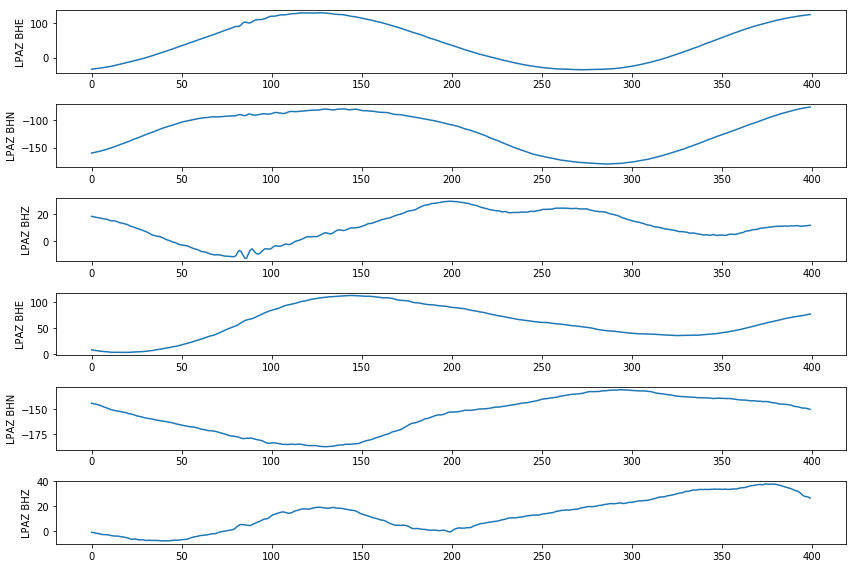

In [9]:
fig = plt.figure(figsize=(12,8))
n = 6

for index, waverow in waverows.head(n).iterrows():
    
    waveform = numpy.array(struct.unpack('%sf' % waverow['NSAMP'], codecs.decode(waverow['SAMPLES'], 'hex_codec')))
    ax = fig.add_subplot(n,1,index+1)
    ax.plot(waveform)
    ax.set_ylabel("%s %s" % (waverow['STA'], waverow['CHAN']))
    
plt.tight_layout()


### Filtered signal

In [10]:
from scipy import signal
import numpy

def butter_bandpass(lowcut, highcut, fs, order=3):
     nyq = 0.5 * fs
     low = lowcut / nyq
     high = highcut / nyq
     b, a = signal.butter(order, [low, high], btype='band')
     return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    if data is None:
        return None

    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    n = data.shape[0]
    window = signal.tukey(n*3)
    #mirror extension of data by iteself on both ends
    data_ext = numpy.hstack([data[::-1], data, data[::-1]])
    y = signal.lfilter(b, a, data_ext*window)
    return y[n:2*n]


In [11]:
F_LO = 1.0
F_HI = 6.0

TRANS_CHAN = {'BHE': 'A', 'BHN': 'B', 'BHZ': 'C'}
TRANS_CLASS = {'N': 0, 'regS': 1, 'regP': 2, 'tele': 3}

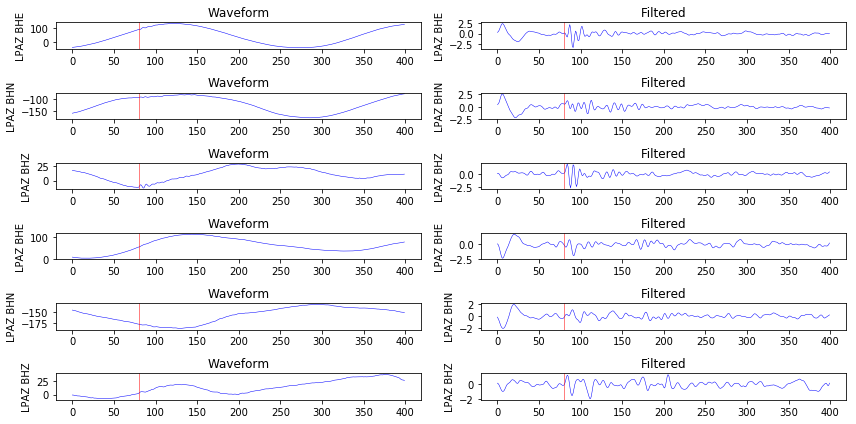

In [12]:
n = 6
fig = plt.figure(figsize=(12,n))


for index, waverow in waverows.head(n).iterrows():
    
    waveform = numpy.array(struct.unpack('%sf' % waverow['NSAMP'], codecs.decode(waverow['SAMPLES'], 'hex_codec')))
    ax = fig.add_subplot(n,2,2*index+1)
    ax.plot(waveform, color='b', lw=0.5)
    ax.set_ylabel("%s %s" % (waverow['STA'], waverow['CHAN']))
    ax.set_title('Waveform')
    ax.axvline(80, color='r', lw=0.5)
    
    waveform_filt = butter_bandpass_filter(waveform, F_LO, F_HI, waverow['SAMPRATE'])
    ax = fig.add_subplot(n,2,2*index+2)
    ax.plot(waveform_filt, color='b', lw=0.5)
    ax.set_ylabel("%s %s" % (waverow['STA'], waverow['CHAN']))
    ax.set_title('Filtered')
    ax.axvline(80, color='r', lw=0.5)
    
plt.tight_layout()

### Export anonymized dataset

In [20]:
def get_header():
    s = ["receptor_id; class; nsamp_per_chan; chan_E_samples; chan_N_samples; chan_Z_samples\n","-----------;------;---------------;---------------;---------------;----------------------------------------------------------->\n"]
    return s
    
def process_row(iid, waverow):
    nsamp = waverow['NSAMP']
    channel = TRANS_CHAN[waverow['CHAN']]
    class_phase = TRANS_CLASS[waverow['CLASS_PHASE']]
    waveform = numpy.array(struct.unpack('%sf' % nsamp, codecs.decode(waverow['SAMPLES'], 'hex_codec')))
    waveform_filt = butter_bandpass_filter(waveform, F_LO, F_HI, waverow['SAMPRATE'])  
    csv_vector = ",".join(map(str, numpy.round(waveform_filt, 5)))
    
    return "%7.7d;%d;%d;%s" % (iid, class_phase, nsamp, csv_vector)

def process_row_just_samples(iid, waverow):
    nsamp = waverow['NSAMP']
    channel = TRANS_CHAN[waverow['CHAN']]
    class_phase = TRANS_CLASS[waverow['CLASS_PHASE']]
    waveform = numpy.array(struct.unpack('%sf' % nsamp, codecs.decode(waverow['SAMPLES'], 'hex_codec')))
    waveform_filt = butter_bandpass_filter(waveform, F_LO, F_HI, waverow['SAMPRATE'])  
    csv_vector = ",".join(map(str, numpy.round(waveform_filt, 5)))
    
    return "%s" % csv_vector

In [21]:
with open('dataset_timeseries_3ch.txt', 'w+') as f:
    f.writelines(get_header())
    for i in range(int(waverows.size/3.)):
        line = "%s;%s;%s;\n" % (process_row(i, waverows.iloc[3*i]), process_row_just_samples(i, waverows.iloc[3*i+1]), process_row_just_samples(i, waverows.iloc[3*i+2]))
        #lines.append(process_row(iid, waverows.iloc[3*i+1]))
        #lines.append(process_row(iid, waverows.iloc[3*i+2]))
        f.writelines([line])

IndexError: single positional indexer is out-of-bounds

In [22]:
s = """0353868;0;400;-0.29683,-0.92092,-1.24942,-0.91891,-0.24879,0.12063,-0.08358,-0.48209,-0.64557,-0.5903,-0.45403,-0.33848,-0.38294,-0.57478,-0.71455,-0.5935,-0.10017,0.63026,1.16169,1.18778,0.89542,0.61279,0.39328,0.12091,-0.21092,-0.48929,-0.63335,-0.53033,-0.12061,0.26419,0.18158,-0.31125,-0.70325,-0.53238,0.21272,1.07325,1.52329,1.3913,0.81555,0.02047,-0.6067,-0.75587,-0.61713,-0.45836,-0.39306,-0.85953,-2.11471,-3.50842,-4.25107,-4.1523,-3.31307,-1.93393,-0.35249,1.13159,2.3439,3.19153,3.66016,3.80706,3.72931,3.51148,3.20554,2.83176,2.3562,1.76156,1.1295,0.58662,0.221,0.02927,-0.07617,-0.18116,-0.34965,-0.64211,-1.04082,-1.45267,-1.60708,-0.90202,0.92752,3.04757,4.10297,3.41975,1.47937,-0.65659,-2.22786,-3.08377,-3.4918,-3.78028,-4.02762,-4.10549,-3.91291,-3.36452,-2.42804,-1.38896,-0.66104,-0.35213,-0.34457,-0.49574,-0.5966,-0.42973,0.07073,0.79453,1.51037,1.9426,1.93153,1.61667,1.38967,1.48986,1.75216,1.87011,1.71265,1.33414,0.82429,0.27323,-0.18929,-0.4757,-0.58149,-0.49932,-0.18785,0.31719,0.778,0.89344,0.57156,-0.06335,-0.6982,-0.91689,-0.7172,-0.54796,-0.58821,-0.57334,-0.27406,0.19997,0.53407,0.51212,0.15461,-0.29349,-0.54699,-0.47974,-0.21002,-0.08831,-0.37373,-1.06035,-2.04053,-3.08825,-3.88736,-4.12611,-3.52404,-2.07292,-0.16219,1.66537,3.02147,3.79666,4.0706,4.00632,3.77668,3.47722,3.12631,2.72441,2.27764,1.79551,1.29119,0.79048,0.33055,-0.06525,-0.4032,-0.7006,-0.96201,-1.1802,-1.35128,-1.47331,-1.5385,-1.54298,-1.50314,-1.45052,-1.38764,-1.27972,-1.11837,-0.93642,-0.75636,-0.59172,-0.49024,-0.47903,-0.46657,-0.33734,-0.12594,0.0552,0.18701,0.32343,0.49467,0.68131,0.83613,0.91218,0.87492,0.73935,0.58163,0.45948,0.37145,0.28543,0.17301,0.03691,-0.12851,-0.33041,-0.53933,-0.56305,0.17752,2.00887,4.09594,5.16415,4.66554,2.79826,0.26139,-1.97613,-3.20775,-3.34457,-2.8001,-2.14555,-1.81419,-1.91223,-2.29258,-2.7466,-2.96425,-2.72522,-2.17793,-1.54975,-0.93743,-0.43639,-0.1387,-0.04065,0.06977,0.45929,1.07613,1.55336,1.57077,1.15309,0.67088,0.54104,0.87522,1.44877,1.96074,2.18338,2.0139,1.52064,0.82779,0.10945,-0.28988,-0.16667,0.22066,0.46407,0.33022,-0.18851,-0.75101,-0.96253,-0.93213,-0.93548,-0.89891,-0.76072,-0.62851,-0.46267,-0.1957,0.08622,0.28961,0.39937,0.44897,0.43915,0.28383,-0.14964,-1.03101,-2.30674,-3.41271,-3.8087,-3.53026,-2.80169,-1.696,-0.32158,1.09171,2.29115,3.10822,3.5191,3.61375,3.50302,3.23786,2.85574,2.45726,2.12908,1.85966,1.57738,1.21913,0.77452,0.28449,-0.18438,-0.5693,-0.84757,-1.05306,-1.26401,-1.50771,-1.68827,-1.71112,-1.59218,-1.39384,-1.17551,-1.00982,-0.94219,-0.91456,-0.82843,-0.69408,-0.57436,-0.47054,-0.36356,-0.27014,-0.19564,0.25931,1.7828,4.12893,5.8995,5.93295,4.25957,1.79102,-0.59194,-2.33508,-3.04875,-2.86673,-2.45355,-2.3026,-2.47999,-2.80932,-3.00906,-2.98704,-2.89991,-2.71637,-2.24287,-1.53224,-0.69922,0.20788,0.89592,1.11336,1.06849,1.01704,0.95003,0.85064,0.81028,0.92879,1.22084,1.63851,2.06945,2.20878,1.85451,1.25381,0.70809,0.25342,-0.09898,-0.2315,-0.05313,0.34583,0.71217,0.79947,0.46721,-0.22109,-0.94751,-1.38007,-1.36106,-0.86353,-0.08276,0.52388,0.53243,-0.00863,-0.54561,-0.69892,-0.59424,-0.41724,-0.2618,-0.2536,-0.44794,-0.71726,-0.93159,-1.32695,-2.12163,-2.84845,-2.96501,-2.5823,-1.96876,-1.10605,0.03523,1.28469,2.36918,3.05973,3.30679,3.26292,3.12789,3.01842,2.93863,2.81475,2.56879,2.15344,1.5951,1.01086,0.50839,0.1044,-0.2472,-0.57681,-0.88701,-1.19942,-1.50128;-0.28831,-0.91805,-1.25201,-0.91917,-0.24198,0.13106,-0.07703,-0.48234,-0.64584,-0.57939,-0.42885,-0.30923,-0.36547,-0.57844,-0.73536,-0.61744,-0.11495,0.62472,1.15648,1.17729,0.88323,0.60626,0.39376,0.12331,-0.20957,-0.48711,-0.62737,-0.51934,-0.10688,0.27531,0.18462,-0.31952,-0.71994,-0.54622,0.21172,1.08234,1.53337,1.39783,0.81623,0.01469,-0.61477,-0.76191,-0.61996,-0.45882,-0.39526,-0.86646,-2.12116,-3.50629,-4.23971,-4.13902,-3.30377,-1.92663,-0.34357,1.1406,2.34893,3.19244,3.66403,3.82089,3.74823,3.5218,3.20146,2.81938,2.33956,1.73643,1.093,0.54412,0.1843,0.01134,-0.07047,-0.15874,-0.32214,-0.62179,-1.03896,-1.47247,-1.63967,-0.93222,0.91074,3.04582,4.11002,3.42711,1.48328,-0.65436,-2.22394,-3.07531,-3.47585,-3.75213,-3.9837,-4.04829,-3.85099,-3.31233,-2.40231,-1.3967,-0.69464,-0.39522,-0.38012,-0.51622,-0.60712,-0.43802,0.06222,0.78585,1.50345,1.94226,1.94064,1.63275,1.40403,1.49137,1.73774,1.84772,1.69278,1.32294,0.82348,0.28066,-0.18078,-0.47513,-0.59201,-0.51421,-0.19596,0.32152,0.79207,0.91102,0.58466,-0.06356,-0.71312,-0.94005,-0.74428,-0.57331,-0.59864,-0.56166,-0.24785,0.22879,0.558,0.52842,0.16284,-0.29202,-0.54922,-0.48354,-0.21334,-0.08637,-0.36317,-1.04496,-2.02664,-3.07709,-3.88019,-4.12769,-3.53338,-2.08277,-0.16878,1.66075,3.01803,3.79442,4.06408,3.98653,3.74303,3.44087,3.10065,2.71435,2.28018,1.80844,1.31278,0.81405,0.34832,-0.05633,-0.40051,-0.70011,-0.96316,-1.1835,-1.35607,-1.47929,-1.54315,-1.54204,-1.4964,-1.44189,-1.38091,-1.27582,-1.11659,-0.93894,-0.76618,-0.60651,-0.50485,-0.48982,-0.46857,-0.3266,-0.1066,0.07556,0.20449,0.33497,0.49587,0.67262,0.82664,0.91015,0.87953,0.74537,0.58586,0.46202,0.37211,0.28215,0.16516,0.02587,-0.14032,-0.34281,-0.55607,-0.58445,0.15627,1.99052,4.08156,5.15868,4.67474,2.81939,0.28421,-1.95869,-3.19586,-3.33413,-2.78614,-2.12692,-1.79556,-1.90126,-2.29129,-2.74652,-2.95591,-2.70819,-2.16029,-1.54119,-0.94106,-0.44789,-0.14968,-0.04339,0.07363,0.4585,1.0609,1.5251,1.54095,1.12953,0.65107,0.52382,0.86777,1.45506,1.9724,2.18792,2.00579,1.50629,0.8229,0.12453,-0.25941,-0.13485,0.24023,0.46674,0.3248,-0.185,-0.72963,-0.93328,-0.91092,-0.92896,-0.9076,-0.78273,-0.65785,-0.49235,-0.22193,0.06673,0.28215,0.40487,0.45975,0.44688,0.28718,-0.14872,-1.03178,-2.306,-3.40643,-3.79873,-3.51886,-2.78696,-1.67913,-0.30819,1.09722,2.28755,3.09861,3.5107,3.61137,3.50363,3.23446,2.8448,2.43999,2.10846,1.83968,1.56246,1.21133,0.77252,0.28549,-0.18263,-0.56832,-0.84854,-1.05433,-1.26126,-1.50074,-1.68192,-1.70688,-1.58509,-1.38058,-1.16229,-1.00594,-0.94666,-0.91789,-0.82501,-0.68553,-0.56579,-0.4668,-0.36583,-0.27757,-0.20923,0.23965,1.76186,4.11295,5.89141,5.93199,4.26283,1.79525,-0.58666,-2.32422,-3.02816,-2.83883,-2.42656,-2.28224,-2.46559,-2.79726,-2.99744,-2.97818,-2.8975,-2.71963,-2.24531,-1.52972,-0.69656,0.202,0.87718,1.08304,1.02941,0.97497,0.91691,0.83542,0.81123,0.93984,1.23573,1.64993,2.07298,2.20715,1.85623,1.26415,0.72055,0.25705,-0.10497,-0.23756,-0.05192,0.3522,0.7162,0.79818,0.46885,-0.20607,-0.92044,-1.35119,-1.34025,-0.85868,-0.09585,0.50259,0.51687,-0.01307,-0.54152,-0.69065,-0.58796,-0.4211,-0.27832,-0.27084,-0.44823,-0.69983,-0.91695,-1.33272,-2.14228,-2.86484,-2.96545,-2.56974,-1.95483,-1.10198,0.02599,1.27049,2.36484,3.07027,3.32077,3.26641,3.11596,2.99405,2.9089,2.78802,2.55446,2.15844,1.61832,1.04314,0.53469,0.11226,-0.25797,-0.59683,-0.90446,-1.20502,-1.4941;-0.27707,-0.90427,-1.24008,-0.91595,-0.25056,0.11284,-0.09797,-0.49882,-0.65871,-0.59323,-0.44023,-0.31108,-0.35841,-0.56714,-0.72203,-0.60597,-0.10962,0.62581,1.15828,1.182,0.8899,0.61403,0.40154,0.12534,-0.21778,-0.50226,-0.64467,-0.53432,-0.11562,0.27217,0.18768,-0.30344,-0.68734,-0.50968,0.22982,1.07289,1.50826,1.37373,0.79926,0.00471,-0.61318,-0.74659,-0.59909,-0.43828,-0.37693,-0.86195,-2.14255,-3.55022,-4.29029,-4.17319,-3.30373,-1.89764,-0.30944,1.16066,2.35364,3.18958,3.65797,3.81225,3.73956,3.52002,3.20933,2.8303,2.34795,1.7432,1.10189,0.55827,0.20347,0.0307,-0.06037,-0.16707,-0.34918,-0.65456,-1.05684,-1.46427,-1.60908,-0.88547,0.9649,3.08873,4.12224,3.40513,1.44193,-0.69736,-2.2639,-3.11883,-3.52386,-3.79461,-4.01508,-4.07478,-3.878,-3.33296,-2.40214,-1.36845,-0.648,-0.3519,-0.3567,-0.51233,-0.61063,-0.43645,0.07444,0.80497,1.52133,1.95523,1.95257,1.64776,1.41988,1.50384,1.74604,1.85319,1.69501,1.31772,0.80676,0.25391,-0.20933,-0.4921,-0.58804,-0.49329,-0.17286,0.32926,0.77364,0.87194,0.54656,-0.07619,-0.69034,-0.8934,-0.69689,-0.54323,-0.59058,-0.56922,-0.25934,0.22207,0.55675,0.52811,0.15618,-0.31085,-0.57633,-0.50897,-0.23343,-0.10175,-0.37204,-1.05046,-2.03865,-3.09899,-3.90082,-4.13067,-3.51352,-2.04973,-0.13689,1.68227,3.02877,3.80125,4.07682,4.01219,3.78148,3.48243,3.12982,2.721,2.26284,1.77146,1.26823,0.77767,0.32784,-0.06538,-0.40708,-0.70762,-0.96874,-1.18401,-1.35235,-1.47543,-1.54287,-1.54579,-1.49884,-1.43622,-1.36853,-1.26354,-1.10728,-0.93152,-0.75962,-0.60101,-0.50006,-0.4851,-0.46665,-0.32906,-0.10883,0.07524,0.20145,0.32864,0.49062,0.66677,0.81208,0.88537,0.85404,0.73105,0.58933,0.4802,0.39203,0.29045,0.16072,0.02066,-0.13317,-0.31956,-0.52607,-0.55912,0.18018,2.01695,4.09661,5.14915,4.64293,2.77324,0.23601,-1.9893,-3.19634,-3.31615,-2.77736,-2.14503,-1.83335,-1.93612,-2.30831,-2.74535,-2.94105,-2.68759,-2.14371,-1.53093,-0.9324,-0.43774,-0.1408,-0.03746,0.0818,0.47281,1.07882,1.54113,1.55072,1.1365,0.66353,0.54001,0.87576,1.44963,1.96148,2.18361,2.01214,1.51102,0.80858,0.09395,-0.28362,-0.13837,0.25205,0.48047,0.32452,-0.21008,-0.76856,-0.96357,-0.92232,-0.9217,-0.8897,-0.77103,-0.65992,-0.49808,-0.21879,0.08364,0.30933,0.43066,0.47194,0.44332,0.27531,-0.1631,-1.04867,-2.32246,-3.41703,-3.80574,-3.52665,-2.7903,-1.66833,-0.2809,1.13263,2.31754,3.11359,3.51114,3.60676,3.50515,3.24566,2.85787,2.44431,2.10318,1.83025,1.54806,1.18896,0.74849,0.27024,-0.18706,-0.56877,-0.85206,-1.06211,-1.2694,-1.50668,-1.68645,-1.70955,-1.5863,-1.38465,-1.17105,-1.01512,-0.95079,-0.91428,-0.8145,-0.67109,-0.54784,-0.44485,-0.3435,-0.25897,-0.19117,0.26887,1.80402,4.14632,5.89361,5.90102,4.21244,1.74335,-0.62948,-2.35666,-3.05394,-2.86165,-2.44412,-2.2916,-2.47078,-2.80476,-3.00883,-2.98978,-2.90206,-2.70694,-2.21246,-1.48684,-0.65454,0.2375,0.9055,1.1103,1.05859,0.99806,0.92397,0.82516,0.79026,0.91674,1.21873,1.64466,2.07778,2.21423,1.85974,1.26254,0.71153,0.23705,-0.13603,-0.27227,-0.07608,0.34961,0.73414,0.82308,0.4798,-0.2212,-0.95312,-1.38031,-1.34729,-0.83949,-0.0612,0.53742,0.54148,0.00047,-0.53549,-0.69309,-0.59926,-0.43455,-0.28834,-0.279,-0.45651,-0.70224,-0.90479,-1.3113,-2.12951,-2.8729,-2.99305,-2.60269,-1.97327,-1.09557,0.05014,1.294,2.3718,3.0603,3.31207,3.27868,3.14689,3.02187,2.91693,2.77627,2.53074,2.13175,1.60011,1.04138,0.54639,0.12678,-0.25097,-0.60224,-0.91959,-1.21966,-1.49667;"""


In [25]:
spl = s.split(';')

In [26]:
len(spl)

7

In [30]:
spl[0], spl[1], spl[2]

('0353868', '0', '400')

In [33]:
n1 = spl[3].split(',')
n2 = spl[4].split(',')
n3 = spl[5].split(',')
print(len(n1), len(n2), len(n3))

400 400 400


In [34]:
spl[6]

''